In [2]:
import torch
from loss import *

In [5]:
# Calculate the expected loss manually (using MSE loss)
mse_loss = nn.MSELoss(reduction="none")
masked_loss = MaskedLoss(mse_loss)


y_hat = torch.tensor(
    [
        [[0.9, 0.8], [0.7, 0.6], [0.5, 0.4], [0.3, 0.2], [0.1, 0.0]],
        [[0.5, 0.6], [0.7, 0.8], [0.9, 1.0], [1.1, 1.2], [1.3, 1.4]],
        [[1.0, 0.9], [0.8, 0.7], [0.6, 0.5], [0.4, 0.3], [0.2, 0.1]],
    ],
    dtype=torch.float32,
)
y = torch.tensor(
    [
        [[1.0, 0.8], [0.7, 0.6], [0.5, 0.4], [0.3, 0.2], [0.1, 0.0]],
        [[0.5, 0.6], [0.7, 0.8], [0.9, 1.0], [1.1, 1.2], [1.3, 1.4]],
        [[1.0, 0.9], [0.8, 0.7], [0.6, 0.5], [0.4, 0.3], [0.2, 0.1]],
    ],
    dtype=torch.float32,
)
mask = torch.tensor(
    [
        [1, 0, 1, 1, 0],
        [1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1],
    ],
    dtype=torch.float32,
)

# Calculate the loss using the MaskedLoss class
masked_loss = masked_loss.get_loss(y_hat, y, mask)
expected_loss = mse_loss(y_hat, y)

In [6]:
masked_loss

tensor(0.0005)

In [8]:
torch.sum(expected_loss)

tensor(0.0100)

In [1]:
import numpy as np

In [283]:
def calculate_directional_consistency(trajectory):
    """
    Calculate directional consistency of a 3D trajectory.

    Args:
        trajectory (numpy.ndarray): NumPy array of shape (num_frame, 3) representing the 3D trajectory.

    Returns:
        float: Variance of the angles between consecutive direction vectors.
    """
    if trajectory.shape[0] < 2:
        raise ValueError("Trajectory must have at least two data points for directional consistency calculation.")

    # Compute direction vectors between consecutive points
    direction_vectors = np.diff(trajectory, axis=0)

    # Calculate angles between consecutive direction vectors
    angles = []
    for i in range(1, len(direction_vectors)):
        v1 = direction_vectors[i - 1]
        v2 = direction_vectors[i]
        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
        angles.append(angle)

    # Calculate variance of the angles
    variance = np.var(angles)

    return variance

# Example usage:
if __name__ == "__main__":
    # Create a sample 3D trajectory (num_frame, 3)
    sample_trajectory = np.array([[0.0, 0.0, 0.0],
                                   [1.0, 0.0, 0.0],
                                   [2.0, 0.0, 0.0],
                                   [2.0, 1.0, 0.0],
                                   [2.0, 2.0, 0.0]])
    
    sample_trajectory = np.random.rand(50, 3)

    # Calculate directional consistency
    variance = calculate_directional_consistency(sample_trajectory)

    print(f"Directional consistency (variance of angles): {variance}")


Directional consistency (variance of angles): 0.3138348994231784


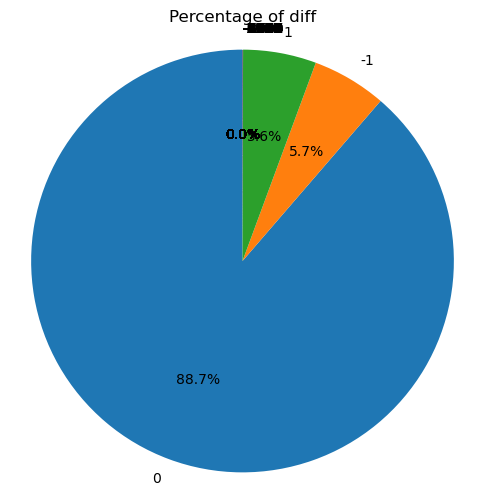

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from paths import bsc_path

log_path = os.path.join(bsc_path, "word_log.csv")
df = pd.read_csv(log_path)

# Specify the column you want to plot
column_to_plot = 'diff'

# Count the occurrences of each unique value
value_counts = df[column_to_plot].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f'Percentage of {column_to_plot}')
plt.show()


"""
NOTE
There are very occasional words who lost n_frames. 
I am not sure whether we will encounter those in phones, just see. 
"""

In [2]:
import torchaudio
import os
from paths import *

In [3]:
rec, sr = torchaudio.load(os.path.join(bsc_path, "s0101a.wav"))

In [5]:
rec.size(1)

9969854

In [6]:
import pandas as pd

def assign_timestep(df, group_col):
    """
    Assign a "timestep" value to each row based on the order within the group.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.
    - group_col (str): The name of the column containing grouping information.

    Returns:
    - df (pandas.DataFrame): The DataFrame with an additional "timestep" column.
    """
    # Sort the DataFrame by the grouping column (optional but can be useful)
    df = df.sort_values(by=[group_col])

    # Group the DataFrame by the grouping column and assign timesteps within each group
    df['timestep'] = df.groupby(group_col).cumcount() + 1

    return df

# Example usage:
data = {'Group': ['A', 'A', 'B', 'A', 'B', 'B'],
        'Value': [10, 20, 5, 15, 8, 12]}
df = pd.DataFrame(data)

# Assign timesteps based on the 'Group' column
df = assign_timestep(df, 'Group')
print(df)


  Group  Value  timestep
0     A     10         1
1     A     20         2
3     A     15         3
2     B      5         1
4     B      8         2
5     B     12         3


In [2]:
import pandas as pd
from paths import *
import os
from my_utils import time_to_frame
import math
import numpy as np

In [3]:
x = pd.read_csv(os.path.join(compound_word_log_path, "log.csv"))

In [4]:
x = x[x['match_status'] == 1]

In [5]:
phnendt = x['phoneme_endtimes'].astype(str)

In [8]:
word_start_time = x["start_time_word"]

In [9]:
word_start_time

0         32.216575
3         47.307796
4         47.530873
5         47.658958
6         48.144502
            ...    
284614    84.380602
284615    84.457425
284616    84.553457
284617    90.183453
284618    90.477742
Name: start_time_word, Length: 197335, dtype: float64

In [17]:
def time_to_rel_frame(row): 
    start_time = row["start_time_word"]
    return [time_to_frame(float(time) - start_time) for time in row["phoneme_endtimes"].split()]

In [19]:
x.apply(time_to_rel_frame, axis=1)

0                       [12, 32]
3                 [3, 8, 11, 17]
4                        [5, 10]
5         [7, 9, 15, 23, 28, 38]
6                        [5, 13]
                   ...          
284614                    [3, 6]
284615                       [7]
284616               [3, 14, 21]
284617                      [23]
284618               [8, 16, 20]
Length: 197335, dtype: object

In [22]:
phnendt

0                                       32.376593 32.622045
3                   47.354937 47.414937 47.446795 47.530873
4                                       47.597709 47.658958
5         47.755626 47.783379 47.847519 47.949904 48.015...
6                                       48.219087 48.311979
                                ...                        
284614                                  84.428342 84.457425
284615                                            84.553457
284616                          84.59571 84.73509 84.827827
284617                                            90.477742
284618                        90.582979 90.685952 90.731215
Name: phoneme_endtimes, Length: 197335, dtype: object

In [20]:
xxx = phnendt.apply(lambda x: [time_to_frame(float(time)) for time in x.split()])

In [10]:
control_file = x

In [13]:
for idx, row in control_file.iterrows(): 
    start_time = row["start_time_word"]
    time_seq = row["phoneme_endtimes"]
    row["relative_frames"] = [time_to_frame(float(time) - start_time) for time in time_seq.split()]

KeyboardInterrupt: 

In [21]:
xxx

0                                 [2590, 2609]
3                     [3788, 3793, 3795, 3802]
4                                 [3807, 3812]
5         [3820, 3822, 3827, 3835, 3841, 3851]
6                                 [3857, 3864]
                          ...                 
284614                            [6754, 6756]
284615                                  [6764]
284616                      [6767, 6778, 6786]
284617                                  [7238]
284618                      [7246, 7254, 7258]
Name: phoneme_endtimes, Length: 197335, dtype: object

In [37]:
counter = 0
for idx, i in xxx.items(): 
    if np.isnan(np.array(i)).sum() > 0: 
        counter += 1
counter 

0

In [23]:
import matplotlib.pyplot as plt
import numpy as np

In [24]:
def plot_feature_with_boundaries(features, boundaries):
    """
    Plot the features as line graphs with marked boundaries.
    
    Parameters:
    - features: NumPy array of shape (length, 8)
    - boundaries: List of boundary times (frame numbers)
    """
    num_features = features.shape[1]
    num_samples = features.shape[0]

    # Create a time axis (assuming one time unit per sample)
    time_axis = np.arange(num_samples)

    # Create subplots for each feature
    fig, axes = plt.subplots(num_features, 1, figsize=(10, num_features * 2), sharex=True)

    # Plot each feature on a separate subplot
    for i in range(num_features):
        ax = axes[i]
        ax.plot(time_axis, features[:, i], label=f'Feature {i + 1}')

        # Mark boundaries on the plot
        for boundary in boundaries:
            if boundary < num_samples:
                ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

        ax.set_ylabel(f'Feature {i + 1}')

    # Set common xlabel
    plt.xlabel('Time (frames)')

    # Add a legend for the feature lines
    axes[0].legend()

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Replace 'features_array' with your NumPy array and 'boundaries_list' with your list of boundaries
# plot_feature_with_boundaries(features_array, boundaries_list)


In [27]:
def plot_feature_with_boundaries(features, boundaries):
    num_features = features.shape[1]
    num_samples = features.shape[0]

    time_axis = np.arange(num_samples)

    fig, axes = plt.subplots(num_features + 1, 1, figsize=(10, (num_features + 1) * 2), sharex=True)

    # Plot each feature on separate subplots
    for i in range(num_features):
        ax = axes[i]
        ax.plot(time_axis, features[:, i], label=f'Feature {i + 1}')

        for boundary in boundaries:
            if boundary < num_samples:
                ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

        ax.set_ylabel(f'Feature {i + 1}')

    # Plot all dimensions together with different line colors
    ax = axes[num_features]
    for i in range(num_features):
        ax.plot(time_axis, features[:, i], label=f'Feature {i + 1}', alpha=0.5)

    for boundary in boundaries:
        if boundary < num_samples:
            ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

    ax.set_ylabel('All Features')
    ax.legend()

    plt.xlabel('Time (frames)')

    plt.tight_layout()
    plt.show()

In [28]:
# Generate fake feature data (8 features, 100 samples)
np.random.seed(42)
features_array = np.random.randn(100, 8)

# Generate fake boundaries (frame numbers)
boundaries_list = [10, 30, 50, 75]


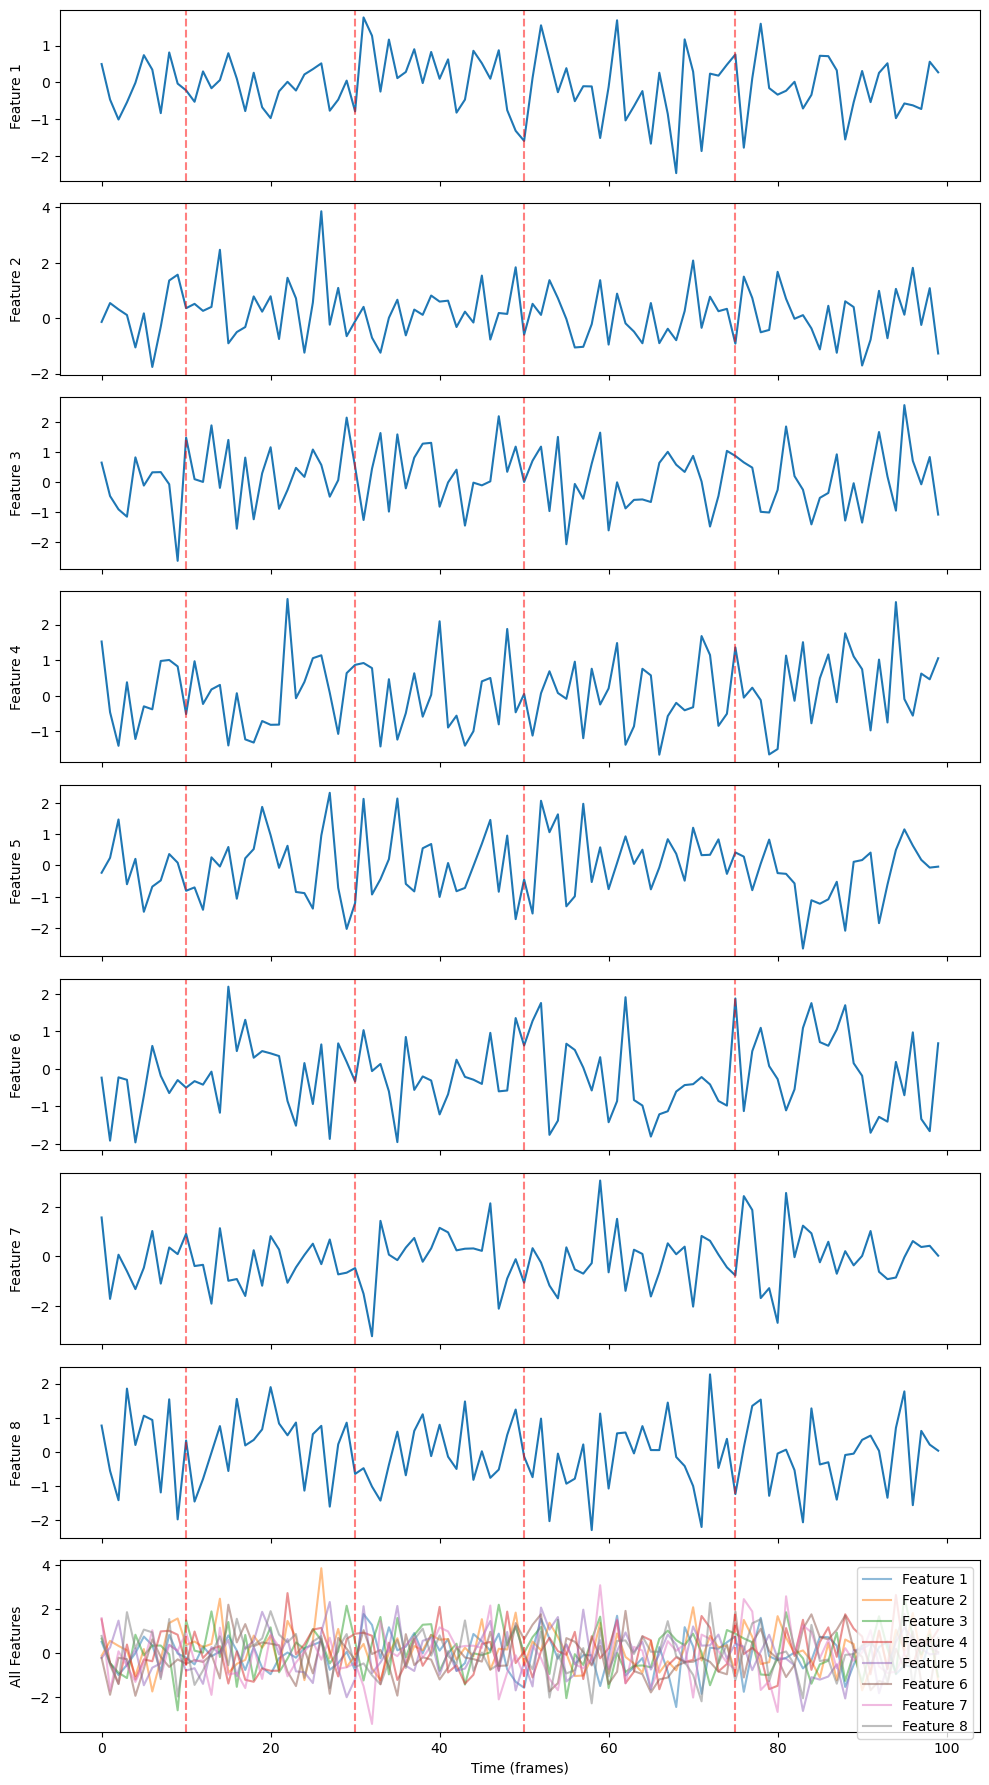

In [29]:
plot_feature_with_boundaries(features_array, boundaries_list)

In [2]:
import numpy as np

# Create a sample numpy array with shape (length, 8)
np.random.seed(42)
data = np.random.rand(3, 8)

# Calculate the delta along the length axis
delta_data = np.diff(data, axis=0)

# delta_data will have shape (length - 1, 8)
print(delta_data)


[[ 0.22657489 -0.24264173 -0.71140945  0.37125137  0.676424    0.05634459
   0.12374136 -0.68277164]
 [-0.29687277 -0.18331615  0.41136052 -0.67868071 -0.22058975 -0.07284525
   0.11031968  0.18295733]]


In [1]:
from bnd_detect_tools import *

In [2]:
def delta_hrs(hrs): 
    # hs = hidden representation signal
    return np.diff(hrs, axis=0)

In [3]:
def batch_delta_hrs(batch_hrs, sel=0): 
    return [delta_hrs(hrs[:, sel]) for hrs in batch_hrs]

In [10]:
# Generate fake feature data (8 features, 100 samples)
np.random.seed()
features_array = [np.random.randn(100, 8), np.random.randn(99, 8), np.random.randn(98, 8)]

# Generate fake boundaries (frame numbers)
boundaries_list = [[10, 30, 50, 75], [10, 30, 50, 75], [10, 30, 50, 75]]

In [11]:
x = batch_delta_hrs(features_array)

In [12]:
r, p = thresh_segmentation_eval(batch_delta_hrs(features_array), boundaries_list, tolerance_window=2, diff_thresh_factor=0.018)

In [13]:
x[0].argsort()[::-1]

array([94, 41, 65, 59, 21, 28, 19, 17, 11, 56, 37, 62, 26, 14, 92, 45, 87,
       80, 69, 23, 35, 97, 47, 58, 78, 53,  4, 96, 71, 89, 51, 83, 30, 74,
       76,  8, 85, 25,  5, 48, 38,  1, 63, 52, 84, 81, 43, 33, 75, 29, 73,
       24, 49, 31, 68, 15, 34,  2, 36, 54,  6, 72, 20, 44,  9, 88,  3, 67,
       98, 10, 70, 64,  7, 91, 60, 82, 79, 90, 46, 12,  0, 13, 16, 77, 55,
       42, 86, 39, 93, 32, 50, 57, 40, 66, 22, 27, 95, 61, 18])

In [14]:
r, p

([1.0, 1.0, 1.0], [0.18421052631578946, 0.14705882352941177, 0.25])

In [27]:
    
def generate_boundaries(array, every=4):
    """
    Generate boundary indices every 4 frames along the length axis.

    Parameters:
    - array: NumPy array of shape (length, 8)

    Returns:
    - boundaries: List of boundary indices
    """
    num_samples = array.shape[0]
    boundaries = list(range(every, num_samples, every))
    return boundaries


In [28]:
generate_boundaries(np.random.randn(3, 8))

[]

In [29]:
[1, 2][:-1]

[1]

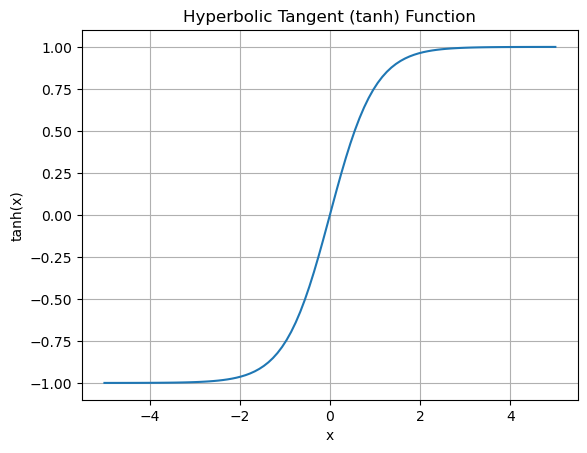

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values
x = np.linspace(-5, 5, 100)

# Calculate tanh values for each x
y = np.tanh(x)

# Create the plot
plt.plot(x, y, label='tanh(x)')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.title('Hyperbolic Tangent (tanh) Function')
plt.grid(True)
# plt.legend()
plt.show()